# Kaggle Competition: M5 Forecasting 
## Estimate the unit sales of Walmart retail goods

- Analise de Series Temporais

- Autor: Rodrigo de Lima Oliveira

- Referências:

    - [DSA] https://www.datascienceacademy.com.br/
    - [MLCOURSER.AI] https://mlcourse.ai/
    - [KAGGLE] https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

# Part 1. Carregando as bibliotecas

In [1]:
# Importando bibliotecas que serao utilizadas neste projeto
import pandas as pd
import numpy as np

from itertools import product
from multiprocessing import Pool
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
import scipy.stats as scs
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import datetime
from dateutil.relativedelta import relativedelta 
import time
import gc
import os
from tqdm import tqdm_notebook

# Ignorar warnings
import warnings
warnings.filterwarnings(action="ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = False

# Variavel para indicar o path local
LOCAL_DATA_FOLDER  = 'data/'
KAGGLE_DATA_FOLDER = '/kaggle/input/m5-forecasting-accuracy/'

In [2]:
# Importando bibliotecas do sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# lib de modelos de machine learning
import xgboost as xgb
import lightgbm as lgb

# Part 2. Importando os Dados

In [3]:
# Funcao para reducao da memoria utilizada
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# Funcao para realizar a leitura dos arquivos LOCAL ou do KAGGLE
def read_data():
    
    # Se for local
    if TRAIN_OFFLINE:

        calendar               = pd.read_csv(os.path.join(LOCAL_DATA_FOLDER, 'calendar.csv'))
        sell_prices            = pd.read_csv(os.path.join(LOCAL_DATA_FOLDER, 'sell_prices.csv'))
        sales_train_validation = pd.read_csv(os.path.join(LOCAL_DATA_FOLDER, 'sales_train_validation.csv'))
        submission             = pd.read_csv(os.path.join(LOCAL_DATA_FOLDER, 'sample_submission.csv'))

    # Se estiver no ambiente do Kaggle
    else:
        
        calendar               = pd.read_csv(os.path.join(KAGGLE_DATA_FOLDER, 'calendar.csv'))
        sell_prices            = pd.read_csv(os.path.join(KAGGLE_DATA_FOLDER, 'sell_prices.csv'))
        sales_train_validation = pd.read_csv(os.path.join(KAGGLE_DATA_FOLDER, 'sales_train_validation.csv'))
        submission             = pd.read_csv(os.path.join(KAGGLE_DATA_FOLDER, 'sample_submission.csv'))

    calendar               = reduce_mem_usage(calendar)
    sell_prices            = reduce_mem_usage(sell_prices)
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    submission             = reduce_mem_usage(submission)
        
    return calendar, sell_prices, sales_train_validation, submission


In [4]:
# Leitura dos dados e aplicando redução de memória
calendar, sell_prices, sales_train_validation, submission = read_data()

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)


# Part 3. Feature Engineering

In [5]:
# Funcao para realizar o merge dos datasets retornando apenas um dataframe
def reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows=55000000, merge=False):
    
    # realizando o reshape dos dados de venda usando melt
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation tem {} linhas e {} colunas'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    #sales_trian_validation = reduce_mem_usage(sales_train_validation)
    
    # separando os registros de teste e validacao
    test_rows = [row for row in submission['id'] if 'validation' in row]
    val_rows = [row for row in submission['id'] if 'evaluation' in row]
    
    test = submission[submission['id'].isin(test_rows)]
    val = submission[submission['id'].isin(val_rows)]
    
    # renomeando as colunas
    test.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 
                    'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 
                    'd_1931', 'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 
                    'd_1940', 'd_1941']
    val.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 
                   'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 
                   'd_1959', 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 
                   'd_1968', 'd_1969']
    
    # obtendo somente dados do produto e removendo registros duplicados 
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # realizando merge com a tabela de produto
    test = test.merge(product, how = 'left', on = 'id')
    val = val.merge(product, how = 'left', on = 'id')
    
    # realizando o reshape dos dados de test e validacao
    test = pd.melt(test, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    val = pd.melt(val, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    # criando uma nova coluna para definir dados de treino, teste e validacao
    sales_train_validation['part'] = 'train'
    test['part'] = 'test'
    val['part'] = 'val'
    
    # criando um so dataset com a juncao de todos os registros de treino, validacao e teste
    data = pd.concat([sales_train_validation, test, val], axis = 0)
    
    # removendo datasets anteriores
    del sales_train_validation, test, val
    
    # selecionando somente alguns registros para treinamento
    data = data.loc[nrows:]
    
    # removendo os dados de validacao
    data = data[data['part'] != 'val']
    
    # realizando o merge com calendario e preco
    if merge:
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day', 'weekday'], inplace = True, axis = 1)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Dataset final para treino tem {} linhas e {} colunas'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    return data

# Funcao para tratamento valores missing transformacao das features categoricas e numericas
def transform(data):
    
    # realizando tratamento em valores missing nas features categoricas
    nan_features_cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features_cat:
        data[feature].fillna('unknown', inplace = True)
    
    # realizando tratamento em valores missing na feature sell_price
    data['sell_price'].fillna(0, inplace = True)
        
    # transformando features categorias em numericas para realizar as previsoes
    encoder = preprocessing.LabelEncoder()
    data['id_encode'] = encoder.fit_transform(data['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 
           'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

In [6]:
%%time

# Realizando o reshape e o merge dos datasets
data = reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows=45000000, merge=True)

# Chamando as funcoes de transformacao dos dados
data = transform(data)

# Visualizando o cabecalho do dataset final
data.head()

# Limpando dados da memória
gc.collect()

Melted sales train validation tem 58327370 linhas e 8 colunas
Dataset final para treino tem 14181090 linhas e 21 colunas
CPU times: user 2min 52s, sys: 42.9 s, total: 3min 35s
Wall time: 3min 35s


0

In [7]:
# Verificando a data de inicio e fim do dataset
print(min(data['date']), max(data['date']))

2015-02-12 2016-05-22


# Part 4. Time Series em Python

### Vamos dar uma olhada em como trabalhar com séries temporais usando esta competição do Kaggle. Então vamos analisar:
- Métodos e modelos que podemos usar para previsões neste dataset
- Aplicar suavização exponencial dupla e tripla
- Analisar estacionariedade
- Criar modelo SARIMA
- Fazer previsões usando o xgboost e lightgbm

In [8]:
data[data['id'] == 'FOODS_3_634_WI_2_validation'].head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
0,FOODS_3_634_WI_2_validation,1246,2,0,8,2,7,train,2015-02-12,11502,6,2,2015,30,4,0,0,0,1,1,3.980469,12468
30490,FOODS_3_634_WI_2_validation,1246,2,0,8,2,3,train,2015-02-13,11502,7,2,2015,30,4,0,0,0,1,0,3.980469,12468
60980,FOODS_3_634_WI_2_validation,1246,2,0,8,2,6,train,2015-02-14,11503,1,2,2015,28,0,0,0,0,0,1,3.980469,12468
91470,FOODS_3_634_WI_2_validation,1246,2,0,8,2,6,train,2015-02-15,11503,2,2,2015,30,4,0,0,0,1,1,3.980469,12468
121960,FOODS_3_634_WI_2_validation,1246,2,0,8,2,7,train,2015-02-16,11503,3,2,2015,22,1,0,0,0,0,0,3.980469,12468


In [9]:
data[(data['id'] == 'FOODS_3_634_WI_2_validation') & (data['demand'] > 0) & (data['part'] == 'train')]

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
0,FOODS_3_634_WI_2_validation,1246,2,0,8,2,7,train,2015-02-12,11502,6,2,2015,30,4,0,0,0,1,1,3.980469,12468
30490,FOODS_3_634_WI_2_validation,1246,2,0,8,2,3,train,2015-02-13,11502,7,2,2015,30,4,0,0,0,1,0,3.980469,12468
60980,FOODS_3_634_WI_2_validation,1246,2,0,8,2,6,train,2015-02-14,11503,1,2,2015,28,0,0,0,0,0,1,3.980469,12468
91470,FOODS_3_634_WI_2_validation,1246,2,0,8,2,6,train,2015-02-15,11503,2,2,2015,30,4,0,0,0,1,1,3.980469,12468
121960,FOODS_3_634_WI_2_validation,1246,2,0,8,2,7,train,2015-02-16,11503,3,2,2015,22,1,0,0,0,0,0,3.980469,12468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13202170,FOODS_3_634_WI_2_validation,1246,2,0,8,2,2,train,2016-04-20,11612,5,4,2016,30,4,0,0,0,0,0,3.980469,12468
13232660,FOODS_3_634_WI_2_validation,1246,2,0,8,2,3,train,2016-04-21,11612,6,4,2016,30,4,0,0,0,0,0,3.980469,12468
13263150,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2016-04-22,11612,7,4,2016,30,4,0,0,0,0,0,3.980469,12468
13293640,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2016-04-23,11613,1,4,2016,30,4,0,0,0,0,0,3.980469,12468


In [10]:
# Selecionar apenas os dados de treino e validação para as analises
# Selecionando somente 1 item para testes: FOODS_3_634_WI_2
df = data[(data['date'] <= '2016-04-24') & (data['id'] == 'FOODS_3_634_WI_2_validation') & (data['demand'] > 0) & (data['demand'] <= 15)]

# Selecionando apenas algumas colunas para a analise e treinamento
df = df[['date','demand','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','snap_WI','sell_price']]

# Transformando a data como index 
df = df.set_index('date')

# Visualizando o resultado do dataset
df.head()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2015-02-12,7,2,0,8,2,30,4,1,3.980469
2015-02-13,3,2,0,8,2,30,4,0,3.980469
2015-02-14,6,2,0,8,2,28,0,1,3.980469
2015-02-15,6,2,0,8,2,30,4,1,3.980469
2015-02-16,7,2,0,8,2,22,1,0,3.980469


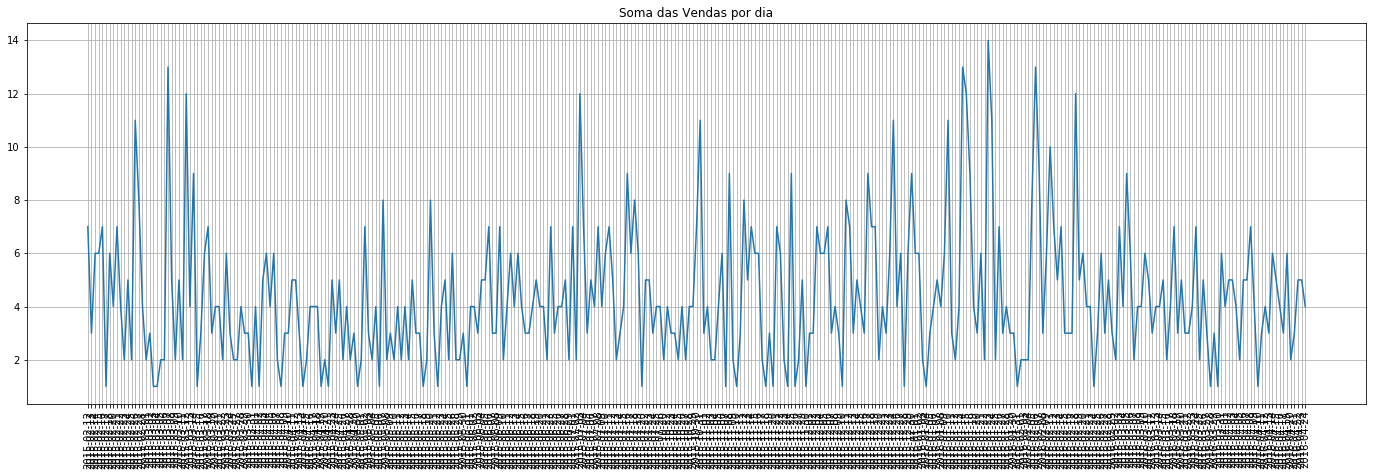

In [11]:
plt.figure(figsize=(24, 7))
plt.plot(df['demand'])
plt.title('Soma das Vendas por dia')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

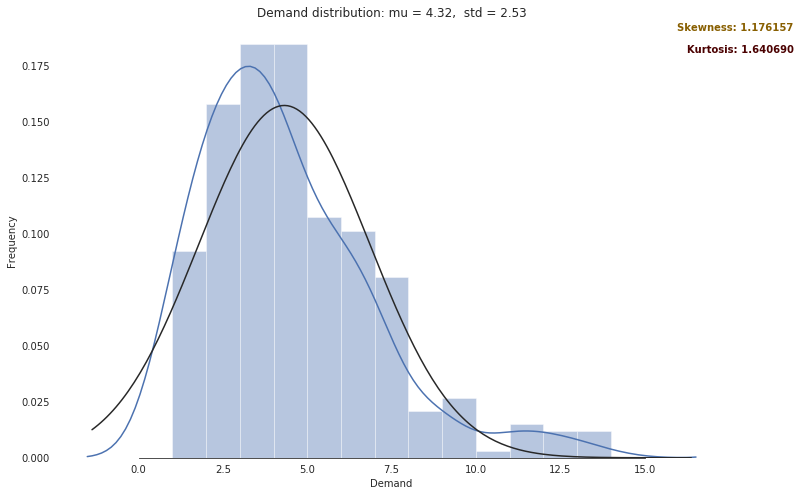

In [12]:
# Visualizando informações de distribuicao da variavel "demand"
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(12, 8))

# Fit a normal distribution
mu, std = norm.fit(df['demand'])

# Verificando a distribuicao de frequencia da variavel "demand"
sns.distplot(df['demand'], color="b", fit = stats.norm)
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Demand")
ax.set(title="Demand distribution: mu = %.2f,  std = %.2f" % (mu, std))
sns.despine(trim=True, left=True)

# Adicionando Skewness e Kurtosis
ax.text(x=1.1, y=1, transform=ax.transAxes, s="Skewness: %f" % df['demand'].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=1.1, y=0.95, transform=ax.transAxes, s="Kurtosis: %f" % df['demand'].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')

plt.show()

## 4.1. Métricas para a previsão
- Antes de começar a realizar as previsões, vamos entender como medir o desempenho de nossas previsões e dar uma olhada na métrica que será usada.

- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): essa é uma métrica interpretável porque tem a mesma unidade de medida que a série inicial, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---

- Mean Absolute Percentage Error: é o mesmo que o MAE, mas é calculado como uma porcentagem, o que é muito conveniente quando você deseja explicar a qualidade do modelo, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## 4.2. Mover, suavizar, avaliar

Vamos começar com uma hipótese: "amanhã será o mesmo de hoje". No entanto, através de um modelo como o $ \ hat {y} _ {t} = y_ {t-1} $, assumiremos que o valor futuro de nossa variável depende da média dos valores anteriores de $ k $. Portanto, usaremos a **média móvel**.


$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [14]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

#  realizando as previsões dos últimos 28 dias
moving_average(df, 28)

5.90656001984127

Infelizmente, não podemos fazer previsões do futuro - para obter o próximo valor, precisamos que os valores anteriores sejam realmente observados. Mas a média móvel tem outro uso - suavizar a série temporal original para identificar tendências. O Pandas tem uma implementação disponível com [`DataFrame.rolling (window).mean()`] (http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Quanto maior a janela, mais suave a tendência. No caso de dados com muito ruído, geralmente encontrados em dados de finanças ou mercado de ações, esse procedimento pode ajudar a detectar padrões comuns.

In [15]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

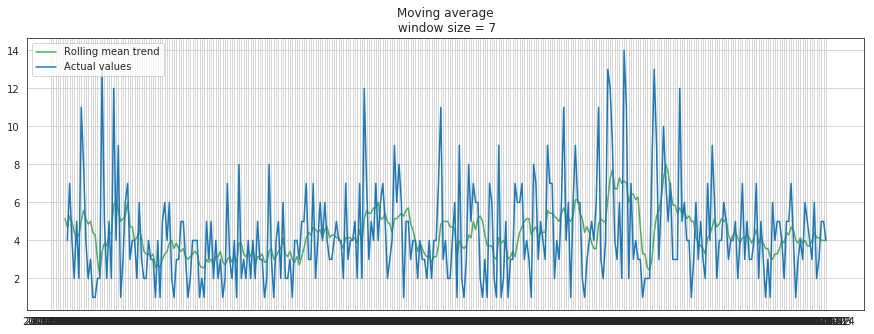

In [16]:
#  Vamos suavizar usando uma janela de 7 dias
plotMovingAverage(df['demand'], 7)

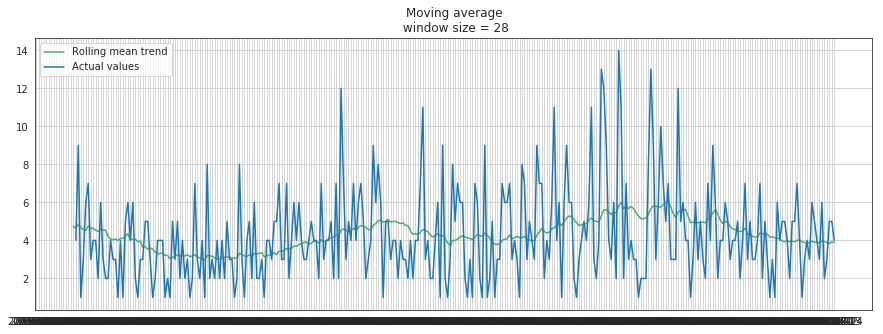

In [17]:
#  Vamos suavizar usando uma janela de 28 dias
plotMovingAverage(df['demand'], 28)

Quando aplicamos a suavização nos dados, podemos ver claramente a dinâmica das vendas no período.

Também podemos traçar os intervalos de confiança.

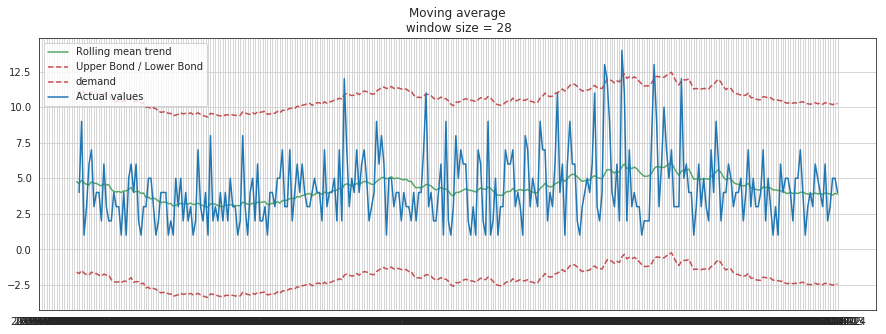

In [18]:
plotMovingAverage(df['demand'], 28, plot_intervals=True)

**Weighted average** é uma modificação simples da média móvel. Os pesos somam `1` com pesos maiores atribuídos a observações mais recentes.


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [19]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [20]:
weighted_average(df['demand'], [0.6, 0.3, 0.1])

4.9

## 4.3 Exponential smoothing

Agora, vamos ver o que acontece se, em vez de ponderar os últimos valores de $ k $ da série temporal, começarmos a ponderar todas as observações disponíveis enquanto diminuímos exponencialmente os pesos à medida que avançamos mais no tempo. Existe uma fórmula para isso **[exponential smoothing (https://en.wikipedia.org/wiki/Exponential_smoothing)** que irá nos ajudar com esta fórmula:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$


Aqui, o valor do modelo é uma média ponderada entre o valor verdadeiro atual e os valores anteriores do modelo. O peso $\alpha$ é chamado de fator de suavização. Ele define a rapidez com que "esqueceremos" a última observação verdadeira. Quanto menor $\alpha$, maior a influência das observações anteriores e mais suave será a série.

A exponencialidade está oculta na recursividade da função - multiplicamos por $(1-\alpha)$ a cada passada, o que já contém uma multiplicação por $(1-\alpha)$ dos valores anteriores do modelo.

In [21]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [22]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

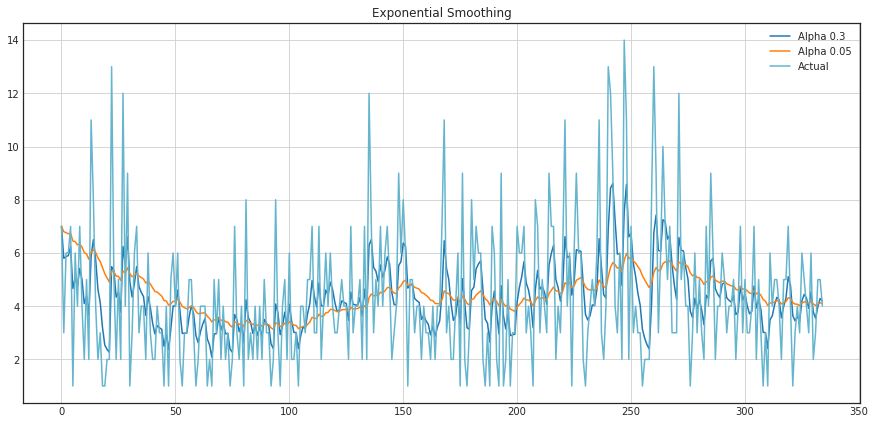

In [23]:
plotExponentialSmoothing(df['demand'], [0.3, 0.05])

## 4.4 Double exponential smoothing

Até agora, os métodos apresentados foram para uma única previsão de um ponto futuro (com uma boa suavização). Isso é legal, mas também não é suficiente. Vamos estender a suavização exponencial para que possamos prever dois pontos futuros (e claro, também incluiremos mais suavização).

A decomposição em série nos ajudará obtendo dois componentes: intercept (nível) $\ell$ e slope (tendência) $b$. Aprendemos a prever intercept (ou valor esperado da série) com nossos métodos anteriores; agora, aplicaremos a mesma suavização exponencial à tendência, assumindo que a direção futura das mudanças na série temporal depende das alterações ponderadas anteriores. Como resultado, obtemos o seguinte conjunto de funções:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$


A primeira descreve o intercept, que depende do valor atual da série. O segundo termo agora está dividido em valores anteriores do nível e da tendência. A segunda função descreve a tendência, que depende das mudanças de nível na etapa atual e do valor anterior da tendência. Nesse caso, o coeficiente $\beta$ é um peso para a suavização exponencial. A previsão final é a soma dos valores do modelo do intercept e da tendência.

In [24]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [25]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

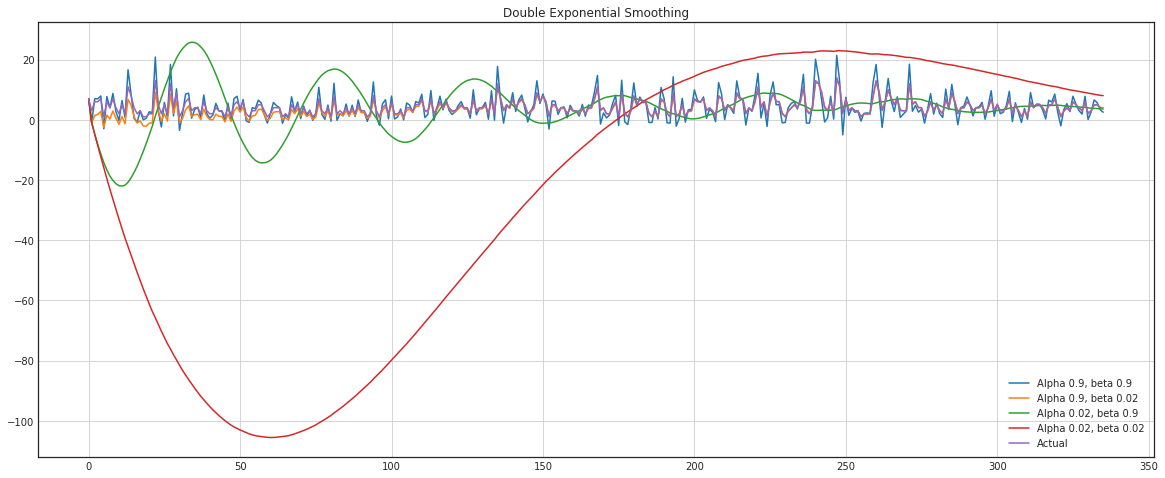

In [26]:
plotDoubleExponentialSmoothing(df['demand'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

Agora temos que ajustar dois parâmetros: $\alpha$ e $\beta$. O primeiro é responsável pela suavização da série em torno da tendência, a segunda pela suavização da própria tendência. Quanto maiores os valores, maior o peso das observações mais recentes e menos suavizada será a série.

## 4.5 Triple exponential smoothing a.k.a. Holt-Winters

Vimos a suavização exponencial e a dupla suavização exponencial. Desta vez, vamos entrar em suavização exponencial triplo.


A idéia é adicionar um terceiro componente - a sazonalidade. Isso significa que não devemos usar esse método se não for esperado que nossa série temporal tenha sazonalidade. Os componentes sazonais do modelo explicam variações repetidas em torno da interceptação e tendência e serão especificadas pela duração da temporada, ou seja, pelo período após o qual as variações se repetem. Para cada observação do período, há um componente separado; por exemplo, se o período for de 28 dias (uma sazonalidade mensal), teremos 28 componentes sazonais, um para cada dia do mês.

Com isso, vamos escrever um novo sistema de equações:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$


O intercept agora depende do valor atual da série menos qualquer componente sazonal correspondente. A tendência permanece inalterada e o componente sazonal depende do valor atual da série menos o intercept e do valor anterior do componente. Leve em consideração que o componente é suavizado em todas os períodos disponíveis; por exemplo, se tivermos um componente de segunda-feira, será calculado apenas a média de outras segundas-feiras. Você pode ler mais sobre como a média funciona e como é feita a aproximação inicial da tendência e dos componentes sazonais [aqui] (http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Agora que temos o componente sazonal, podemos prever não apenas um ou dois passos à frente, mas também um futuro arbitrário $m$, o que é muito bom.

Abaixo está o código para um modelo triplo de suavização exponencial, também conhecido pelos sobrenomes de seus criadores, Charles Holt e seu aluno Peter Winters. Além disso, o método Brutlag foi incluído no modelo para produzir intervalos de confiança:


$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

onde $T$ é a duração do período, $d$ é o desvio previsto. Outros parâmetros foram obtidos da tripla suavização exponencial. Você pode ler mais sobre o método e sua aplicabilidade à detecção de anomalias em séries temporais [aqui] (http://fedcsis.org/proceedings/2012/pliks/118.pdf).

In [27]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## 4.6 Time series cross validation

Antes de começar a construir um modelo, vamos verificar como estimar os parâmetros do modelo automaticamente.

Não há nada incomum aqui; como sempre, temos que escolher uma função de perda adequada para a tarefa que nos dirá quão próximo o modelo se aproxima dos dados. Em seguida, usando a validação cruzada, avaliaremos nossa função de perda escolhida para os parâmetros de modelo fornecidos, calcularemos o gradiente, ajustamos os parâmetros do modelo e assim por diante, eventualmente descendo para o mínimo global.


Você pode estar se perguntando como fazer a validação cruzada para séries temporais porque as séries temporais possuem essa estrutura temporal e não é possível misturar valores aleatoriamente sem preserva essa estrutura. Com a randomização, todas as dependências de tempo entre as observações serão perdidas. É por isso que teremos que usar uma abordagem mais complicada para otimizar os parâmetros do modelo. Não sei se existe um nome oficial para isso, mas em [CrossValidated] (https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection), é possível encontrar algumas respostas para esse método que é "validação cruzada em uma base contínua".

A idéia é bastante simples - treinamos nosso modelo em um pequeno segmento da série cronológica desde o início até $t$, fazemos previsões para as próximas etapas de $t+n$ e calculamos um erro. Em seguida, expandimos nossa amostra de treinamento para o valor $t+n$, fazemos previsões de $t+n$ até $t+2*n$ e continuamos movendo janela de teste da série cronológica até atingirmos a última observação disponível. Como resultado, temos muitas amostras $n$ entre a amostra de treinamento inicial e a última observação.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Agora, sabendo como configurar a validação cruzada, podemos encontrar os parâmetros ideais para o modelo Holt-Winters. Lembre-se de que temos sazonalidade diária, daí o parâmetro slen = 1.

In [28]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=28):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=2) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], 
                            slen=slen, 
                            alpha=alpha, 
                            beta=beta, 
                            gamma=gamma, 
                            n_preds=len(test))
        
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [29]:
%%time

new_data = df['demand']

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, 
               x0=x, 
               args=(new_data, mean_squared_error), 
               method="TNC", 
               bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 28 days
model = HoltWinters(new_data, 
                    slen = 28, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 28, 
                    scaling_factor = 3)

model.triple_exponential_smoothing()

0.027304042320423383 0.05387930013167863 0.0
CPU times: user 5.17 s, sys: 0 ns, total: 5.17 s
Wall time: 5.17 s


In [30]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    
    #error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    error = rmse(series.values, model.result[:len(series)])
    plt.title("RMSE: {0:.2f}".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-60, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

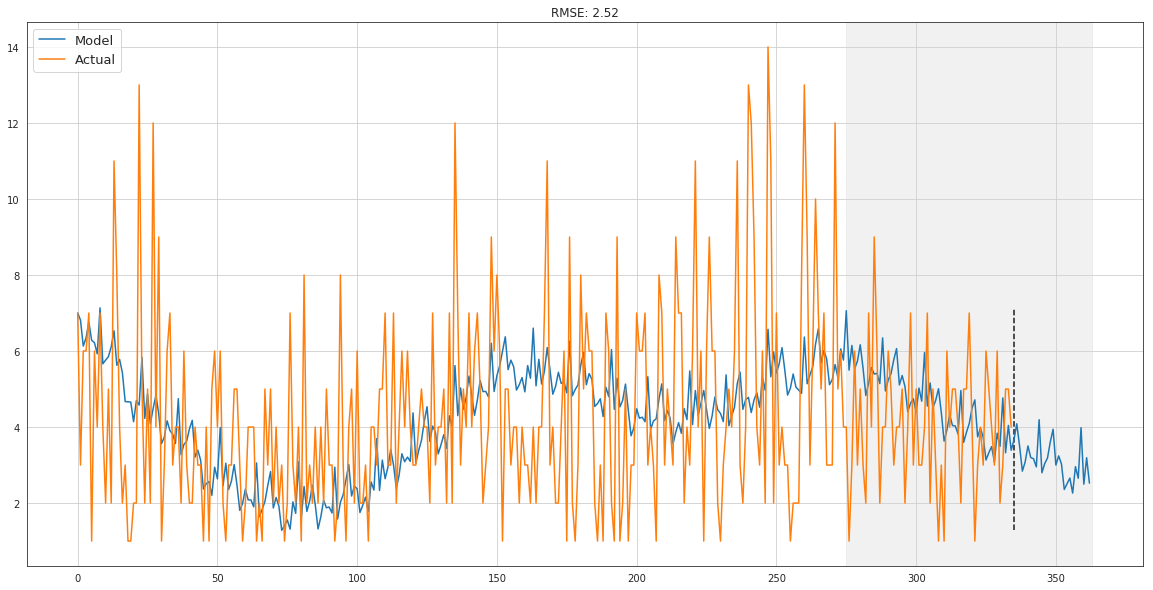

In [31]:
plotHoltWinters(df['demand'])

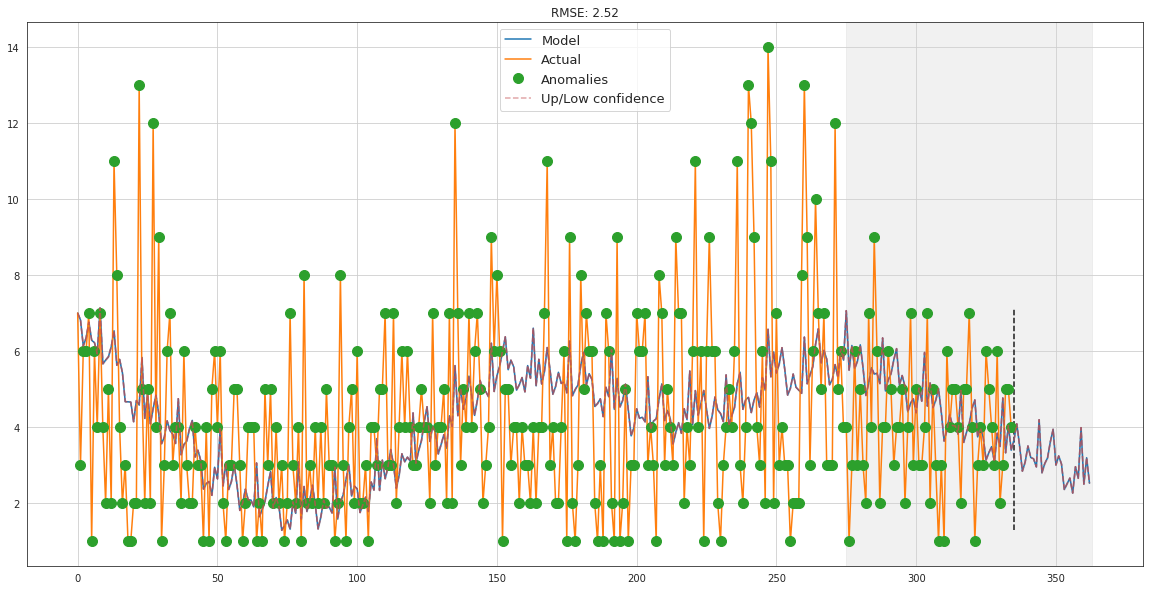

In [32]:
plotHoltWinters(df['demand'], plot_intervals=True, plot_anomalies=True)

A julgar pelos gráficos, nosso modelo conseguiu aproximar com sucesso as séries temporais iniciais, capturando a sazonalidade diária, a tendência geral de queda e até algumas anomalias. Se você observar os desvios do modelo, poderá ver claramente que o modelo reage bastante às mudanças na estrutura da série, mas depois retorna rapidamente o desvio aos valores normais, essencialmente "esquecendo" o passado. Esse recurso do modelo nos permite criar rapidamente sistemas de detecção de anomalias, mesmo para ruídos nos dados da série, sem gastar muito tempo na preparação dos dados e no treinamento do modelo.

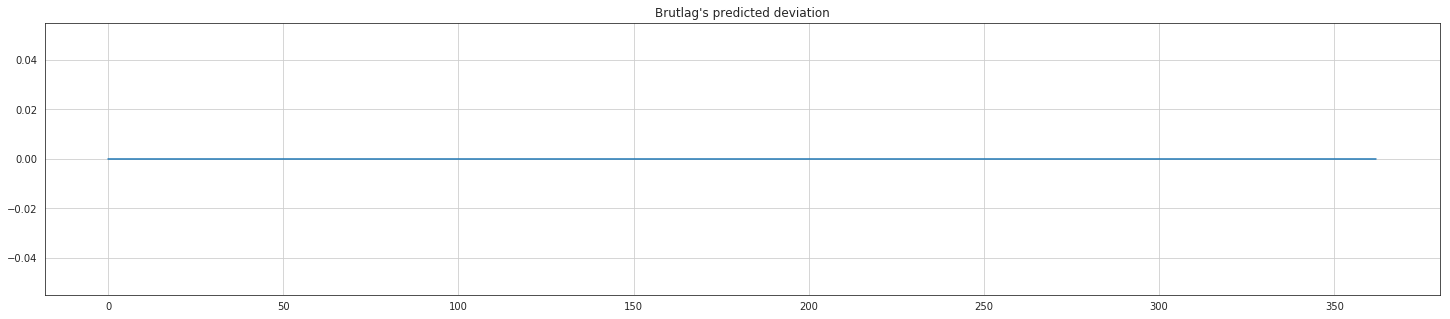

In [33]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## 4.7 Abordagem Econometrica

### Estacionariedade


Antes de começar, devo mencionar uma propriedade importante da série temporal: [**stationarity**] (https://en.wikipedia.org/wiki/Stationary_process).

Se um processo é estacionário, isso significa que ele não altera suas propriedades estatísticas ao longo do tempo, ou seja, sua média e variância. (A constância da variação é chamada de [homoscedasticidade] (https://en.wikipedia.org/wiki/Homoscedasticity)) A função de covariância não depende do tempo, deve depender apenas da distância entre as observações. Você pode ver issonas imagens do post de [Sean Abu] (http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- O gráfico vermelho abaixo não é estacionário porque a média aumenta com o tempo.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Observando a variação de valores ao longo do tempo

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Finalmente, a covariância do i termo e do (i + m) termo não deve ser uma função do tempo. No gráfico a seguir, você notará que o spread se aproxima à medida que o tempo aumenta. Portanto, a covariância não é constante como no gráfico da direita.


<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Então, por que a estacionariedade é tão importante? Porque é fácil fazer previsões em uma série estacionária, pois podemos assumir que as propriedades estatísticas futuras não serão diferentes daquelas atualmente observadas. A maioria dos modelos de séries temporais, de uma maneira ou de outra, tenta prever essas propriedades (média ou variação, por exemplo). As previsões futuras estariam erradas se a série original não estivesse estacionária. Infelizmente, a maioria das séries temporais que vemos fora dos livros didáticos não é estacionária, mas podemos (e devemos) mudar isso.

Então, vamos ver como detectar a não estacionariedade. Analisaremos o ruído branco e os randow walks para aprender a passar de um para outro.

## 4.8 Tratar a Não Estacionariedade e construir o modelo SARIMA

Vamos construir um modelo ARIMA, percorrendo todos os estágios para tornar uma série estacionária.

Aqui está o código para renderizar os gráficos.

In [34]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

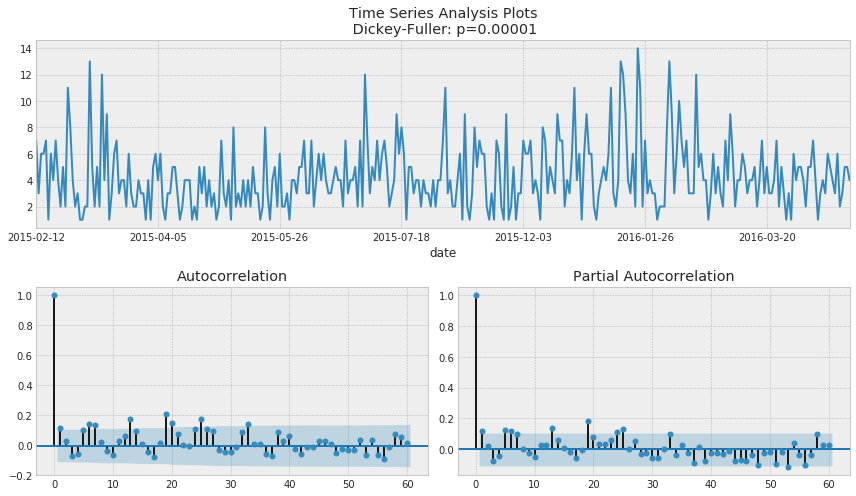

In [35]:
tsplot(df['demand'], lags=60)

Surpreendentemente, as séries iniciais são estacionárias; o teste de Dickey-Fuller rejeitou a hipótese nula de que uma raiz unitária está presente. Na verdade, podemos ver isso no próprio gráfico - não temos uma tendência visível; portanto, a média é constante e a variação é praticamente estável. A única coisa que resta é a sazonalidade, com a qual temos que lidar antes da modelagem. Para fazer isso, vamos usar a "diferença sazonal", que significa uma simples subtração da série de si mesma com um atraso igual ao período sazonal.

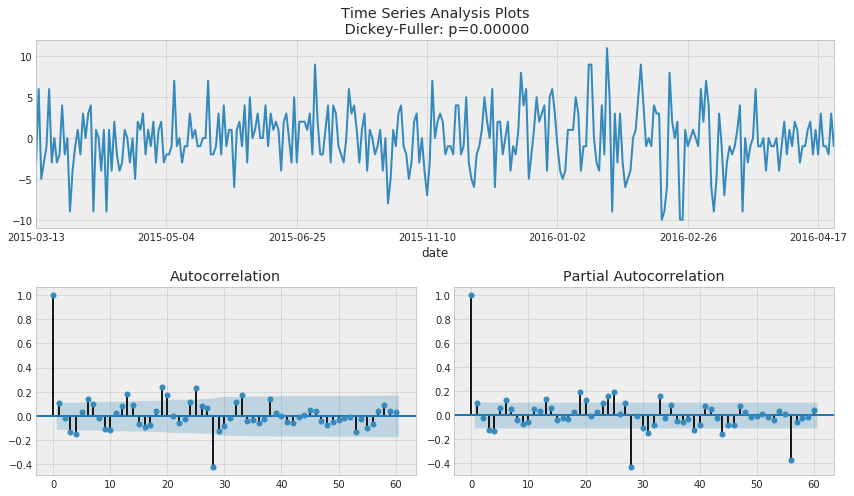

In [36]:
df_diff = df['demand'] - df['demand'].shift(28)
tsplot(df_diff[28:], lags=60)

Agora é muito melhor com a sazonalidade visível desaparecida.

## 4.9 Família ARIMA

Explicarei esse modelo construindo letra por letra. $SARIMA(p, d, q)(P, D, Q, s)$, Média móvel sazonal de regressão automática (Seasonal Autoregression Moving Average model):


- $AR(p)$ - modelo de regressão automática, isto é, regressão da série temporal em si mesma. A suposição básica é que os valores da série atual dependem de seus valores anteriores com algum atraso (ou vários atrasos). O atraso máximo no modelo é referido como $p$. Para determinar o $p$ inicial, é necessário examinar o gráfico do PACF e encontrar o maior atraso significativo o qual a maioria dos outros atrasos se torna insignificante.


- $ MA(q)$ - modelo de média móvel. Sem entrar em muitos detalhes, modela o erro da série cronológica, novamente com a suposição de que o erro atual depende do anterior com algum atraso, conhecido como $q$. O valor inicial pode ser encontrado no gráfico ACF com a mesma lógica de antes.


Vamos combinar nossas 4 primeiras letras:

$AR(p) + MA(q) = ARMA(p, q)$


O que temos aqui é o modelo de média móvel autorregressiva! Se a série é estacionária, pode ser aproximada com estas 4 letras. Vamos continuar.


- $I(d)$ - ordem de integração. Este é simplesmente o número de diferenças não sazonais necessárias para tornar a série estacionária. No nosso caso, é apenas 1 porque usamos as primeiras diferenças.

A adição desta letra às quatro nos dá o modelo $ARIMA$, que pode manipular dados não estacionários com a ajuda de diferenças não sazonais. Ótimo, mais uma letra pela frente!


- $S(s)$ - é responsável pela sazonalidade e igual à duração do tamanho do período da série

Com isso, temos três parametros: $(P, D, Q)$

- $P$ - ordem de regressão automática para o componente sazonal do modelo, que pode ser derivado do PACF. Mas você precisa observar o número de atrasos significativos, que são os múltiplos da duração do período da serie. Por exemplo, se o período é igual a 28 dias e vemos que os atrasos de 28 e 56 são significativas no PACF, isso significa que o $P$ inicial deve ser 2.


- $Q$ - lógica semelhante usando o gráfico ACF.


- $D$ - ordem de integração sazonal. Isso pode ser igual a 1 ou 0, dependendo se as diferenças sazonais foram aplicadas ou não.

Agora que sabemos como definir os parâmetros iniciais, vamos dar uma olhada no gráfico final mais uma vez e definir os parâmetros:

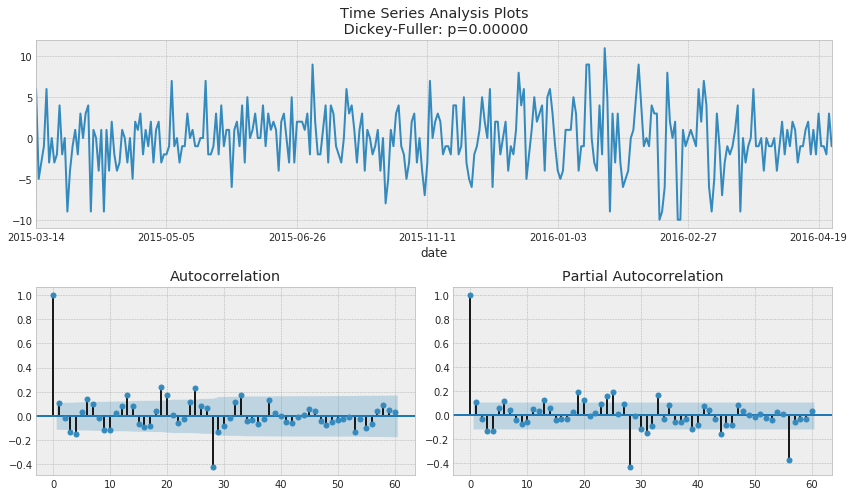

In [37]:
tsplot(df_diff[28+1:], lags=60)

- $p$ é provavelmente 4, já que é o atraso mais significativo no PACF
- $d$ é igual a 1 porque tivemos as primeiras diferenças
- $q$ deve estar em torno de 4, assim como no ACF
- $P$ pode ser 2, uma vez que os atrasos de 28 e 56 são um pouco significativas no PACF
- $D$ novamente é igual a 1 porque realizamos diferenciação sazonal
- $Q$ é provavelmente 1. O 28º atraso no ACF é significativo, enquanto o 56º não.

Vamos testar vários modelos e ver qual é o melhor.

In [38]:
# setting initial values and some bounds for them
ps = range(2, 3)
d=1 
qs = range(2, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 28 # season length is still 28

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [39]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [40]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


CPU times: user 2min 58s, sys: 2min 57s, total: 5min 55s
Wall time: 1min 32s


In [41]:
result_table.head()

,parameters,aic
0,"(2, 2, 0, 1)",1533.675148
1,"(2, 2, 1, 1)",1535.487717
2,"(2, 2, 1, 0)",1601.622217
3,"(2, 2, 0, 0)",1665.317673


In [42]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                     order=(p, d, q),
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               demand   No. Observations:                  335
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 28)   Log Likelihood                -760.838
Date:                              Tue, 24 Mar 2020   AIC                           1533.675
Time:                                      11:57:42   BIC                           1556.017
Sample:                                           0   HQIC                          1542.610
                                              - 335                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8720      0.088     -9.889      0.000      -1.045      -0.699
ar.L2          0.04

Vamos inspecionar os resíduos do modelo.

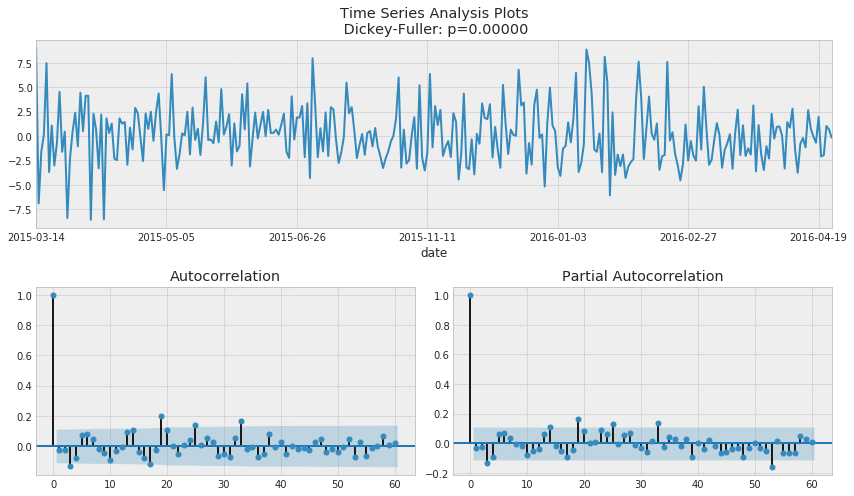

In [43]:
tsplot(best_model.resid[28+1:], lags=60)

É claro que os resíduos são estacionários e não há autocorrelações aparentes. Vamos fazer previsões usando nosso modelo.

In [44]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    dfCopy = series.copy()
    
    dfCopy['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    dfCopy['arima_model'][:s+d] = np.NaN    
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = dfCopy.shape[0], end = dfCopy.shape[0]+n_steps)
    forecast = dfCopy['arima_model'].append(forecast)

    # calculate error, again having shifted on s+d steps from the beginning
    error = rmse(dfCopy['demand'][s+d:], dfCopy['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("RMSE: {0:.2f}".format(error))
    #plt.plot(forecast, color='r', label="model")
    #plt.axvspan(dfCopy.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(dfCopy['demand'], label="actual")
    plt.legend()
    plt.grid(True);

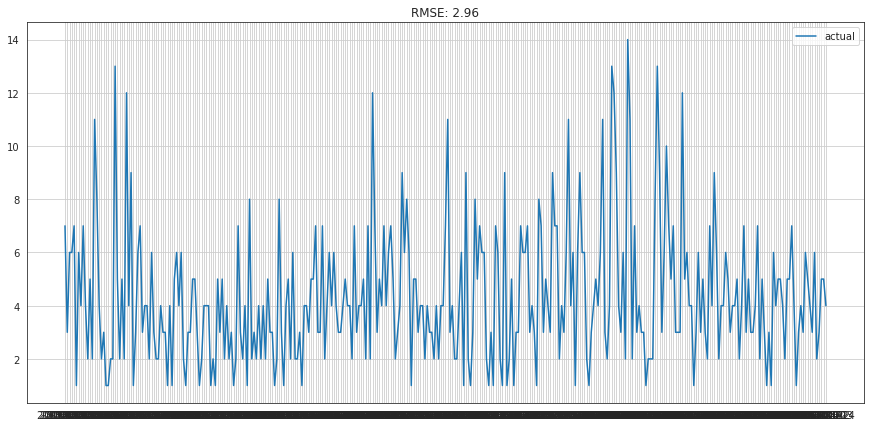

In [45]:
plotSARIMA(df, best_model, 28)

No final, obtivemos previsões muito boas. Nosso modelo errou 2.96 (RMSE), em média, o que é muito, muito bom. No entanto, os custos gerais da preparação dos dados, da preparação da série e da seleção de parâmetros podem não valer essa precisão.

# Part 5. Modelos lineares em séries temporais


Esses modelos analisados até aqui demandam muito tempo para a preparação de dados (como no SARIMA) ou exigem treinamento frequente sobre novos dados (novamente, SARIMA) ou são difíceis de ajustar (bom exemplo - SARIMA). Portanto, muitas vezes é muito mais fácil selecionar algumas features das séries temporais existentes e criar um modelo de regressão linear simples ou, por exemplo, uma random forest.

Essa abordagem não é apoiada pela teoria e quebra várias suposições (por exemplo, o teorema de Gauss-Markov, especialmente para erros não correlacionados), mas é muito útil na prática e é frequentemente usada em competições.


## 5.1 Feature Extraction

Quais as features podemos extrair deste dataset?
* Lags of time series
* Window statistics:
    - Max/min value of series in a window
    - Average/median value in a window
    - Window variance
    - etc.
* Date and time features:
    - Eventos especiais
    - Dia da semana, mês, ano,...
    - Feriados
    - etc.
* Target encoding 
* Forecasts de outros modelos (note que podemos perder o desempenho da previsão dessa maneira)

Vamos analisar alguns dos métodos e ver o que podemos extrair dos dados desta série temporal da competição

## 5.2 Atrasos (lags) da série temporal

Mudando a série $n$ para trás, obtemos uma feature em que o valor atual da série temporal está alinhado com seu valor no tempo $t-n$. Se fizermos uma mudança de 1 lag e treinarmos um modelo com essa nova feature, o modelo poderá prever um passo à frente e observar o estado atual da série. Aumentar o atraso (lag), digamos, até 28, permitirá que o modelo faça previsões 28 passos à frente; no entanto, usará os dados observados nas 28 etapas para trás. Se algo mudar fundamentalmente a série durante esse período não observado, o modelo não capturará essas alterações e retornará previsões com um grande erro. Portanto, durante a seleção do atraso inicial, é preciso encontrar um equilíbrio entre a qualidade ideal da previsão e a duração de previsão.

In [46]:
# Criar uma copia do dataset original
new_df = df.copy()

# Visualizando o dataset
new_df.head()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2015-02-12,7,2,0,8,2,30,4,1,3.980469
2015-02-13,3,2,0,8,2,30,4,0,3.980469
2015-02-14,6,2,0,8,2,28,0,1,3.980469
2015-02-15,6,2,0,8,2,30,4,1,3.980469
2015-02-16,7,2,0,8,2,22,1,0,3.980469


In [47]:
# Adicionando features considerando o atraso da demanda de 7 a 28 dias
for i in range(7, 29):
    new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

In [48]:
# Visualizando o resultado do dataset
new_df.tail()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-20,2,2,0,8,2,30,4,0,3.980469,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0,3.0
2016-04-21,3,2,0,8,2,30,4,0,3.980469,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0
2016-04-22,5,2,0,8,2,30,4,0,3.980469,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0
2016-04-23,5,2,0,8,2,30,4,0,3.980469,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0
2016-04-24,4,2,0,8,2,30,4,0,3.980469,4.0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0


Ótimo, geramos um conjunto de dados aqui. Por que agora não treinamos um modelo?

In [49]:
# para o cross-validation da serie temporal
tscv = TimeSeriesSplit(n_splits=5)

In [50]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test  = X.iloc[test_index:]
    y_test  = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [51]:
y = new_df.dropna()['demand']
X = new_df.dropna().drop(['demand'], axis=1)

In [52]:
# split com 10% para dados de teste
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [53]:
# machine learning em 2 linhas
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmse(y_test, prediction)
    plt.title("RMSE: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

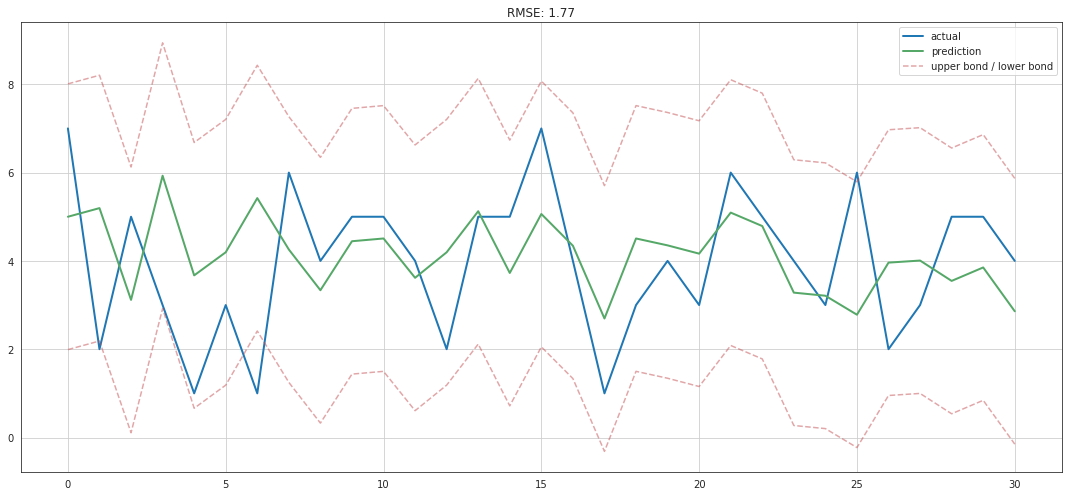

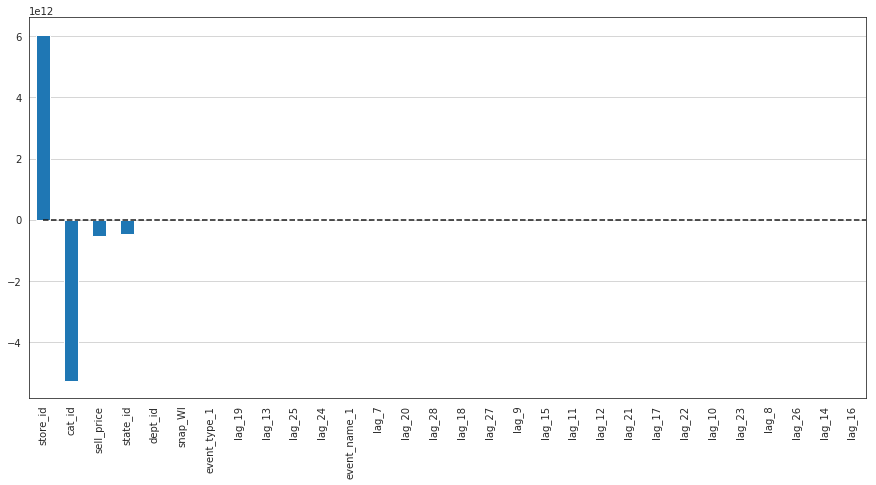

In [55]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Os atrasos (lags) simples e a regressão linear nos deram previsões  distantes do SARIMA em termos de qualidade. Como existem muitas features desnecessárias, faremos a Feature Selection daqui a pouco. Por enquanto, vamos continuar a engenharia!

Adicionaremos algumas features de data. Para fazer isso, precisamos transformar a data no formato `datetime`.

In [56]:
new_df.index = pd.to_datetime(new_df.index)
new_df["day"] = new_df.index.day
new_df["weekday"] = new_df.index.weekday
new_df['is_weekend'] = new_df.weekday.isin([5,6])*1
new_df.tail()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,day,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-20,2,2,0,8,2,30,4,0,3.980469,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0,3.0,20,2,0
2016-04-21,3,2,0,8,2,30,4,0,3.980469,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0,21,3,0
2016-04-22,5,2,0,8,2,30,4,0,3.980469,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,22,4,0
2016-04-23,5,2,0,8,2,30,4,0,3.980469,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,23,5,1
2016-04-24,4,2,0,8,2,30,4,0,3.980469,4.0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,24,6,1


Podemos visualizar o resultado:

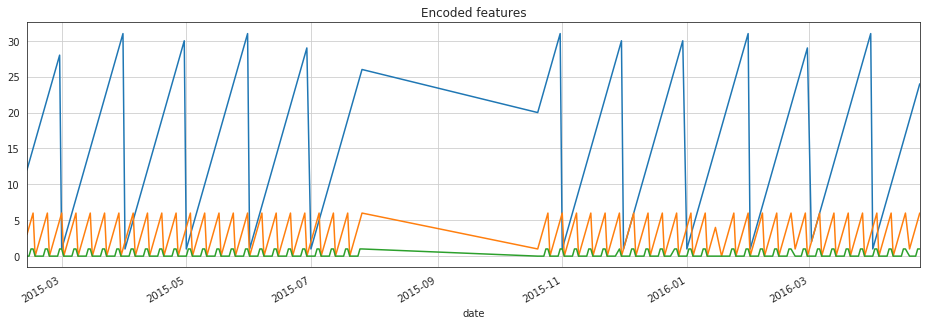

In [57]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
new_df['day'].plot()
new_df['weekday'].plot()
new_df['is_weekend'].plot()
plt.grid(True);

Como agora temos escalas diferentes em nossas features, precisamos transformá-los na mesma escala para explorar a importância, posteriormente, a regularização.

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

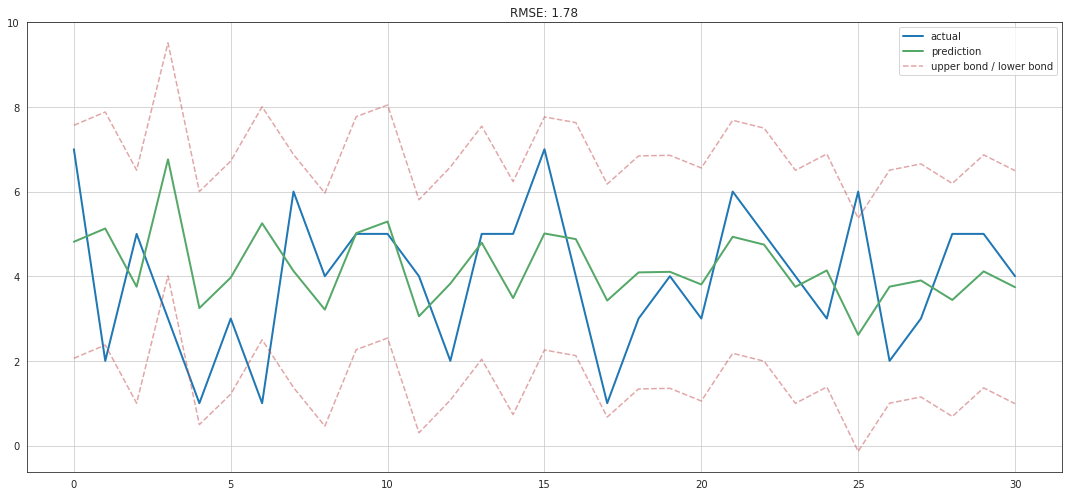

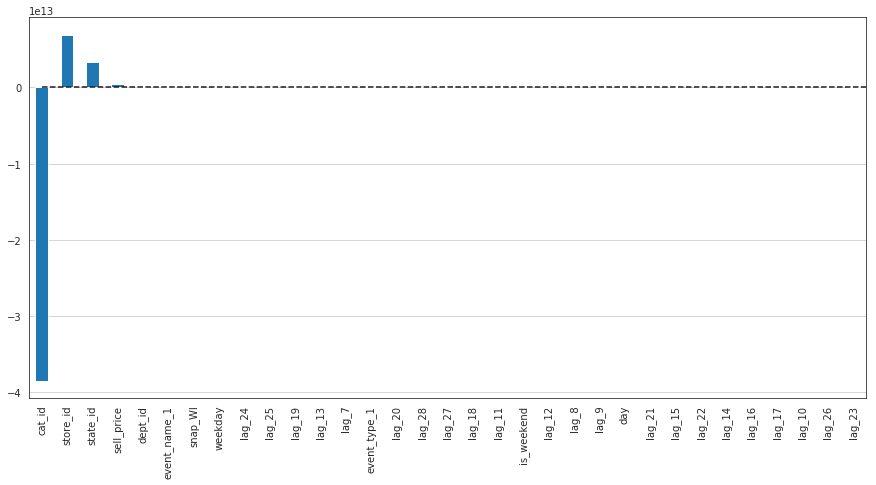

In [59]:
X = new_df.dropna().drop(['demand'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

O erro permaneceu o mesmo.

## 5.3 Target encoding

Gostaria de adicionar outra variante para codificar features categóricas: encoding por valor médio. Se não for desejável criar um conjunto de dados usando muitas variáveis dummy que podem levar à perda de informações e se elas não puderem ser usadas como valores reais devido a conflitos como "0 horas < 23 horas", então é possível codificar uma variável com valores um pouco mais interpretáveis. A idéia natural é codificar com o valor médio da variável de destino. No nosso exemplo, todos os dias da semana podem ser codificados pelo número médio correspondente de vendas durante esse dia. É muito importante garantir que o valor médio seja calculado apenas no conjunto de treinamento (ou apenas na validação cruzada atual), para que o modelo conheça o futuro.

In [60]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

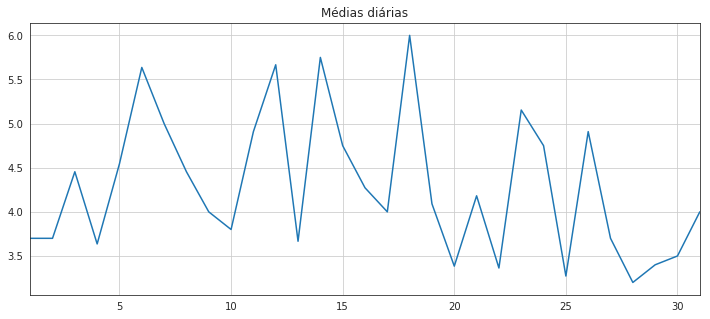

In [61]:
average_day = code_mean(new_df, 'day', "demand")
plt.figure(figsize=(12, 5))
plt.title("Médias diárias")
pd.DataFrame.from_dict(average_day, orient='index')[0].plot()
plt.grid(True);

Finalmente, vamos juntar todas as transformações em uma única função.

In [62]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    new_df = df.copy()

    # lags of series
    for i in range(7, 29):
        new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

    # datetime features
    new_df.index = pd.to_datetime(new_df.index)
    new_df["day"] = new_df.index.day
    new_df["weekday"] = new_df.index.weekday
    new_df['is_weekend'] = new_df.weekday.isin([5,6])*1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(new_df.dropna())*(1-test_size))
        new_df['weekday_average'] = list(map(code_mean(new_df[:test_index], 'weekday', "demand").get, new_df['weekday']))
        new_df["day_average"] = list(map(code_mean(new_df[:test_index], 'day', "demand").get, new_df['day']))

        # frop encoded variables 
        new_df.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = new_df.dropna()['demand']
    X = new_df.dropna().drop(['demand'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

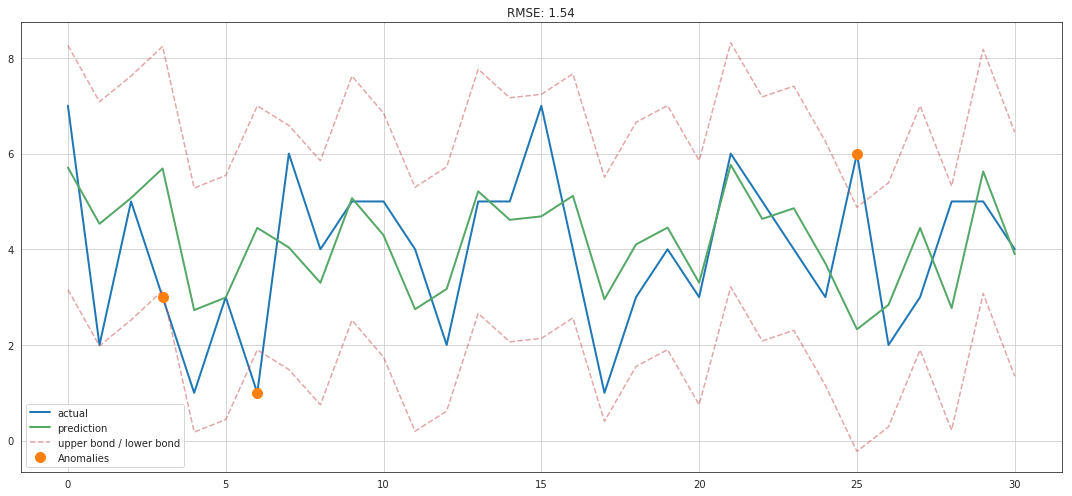

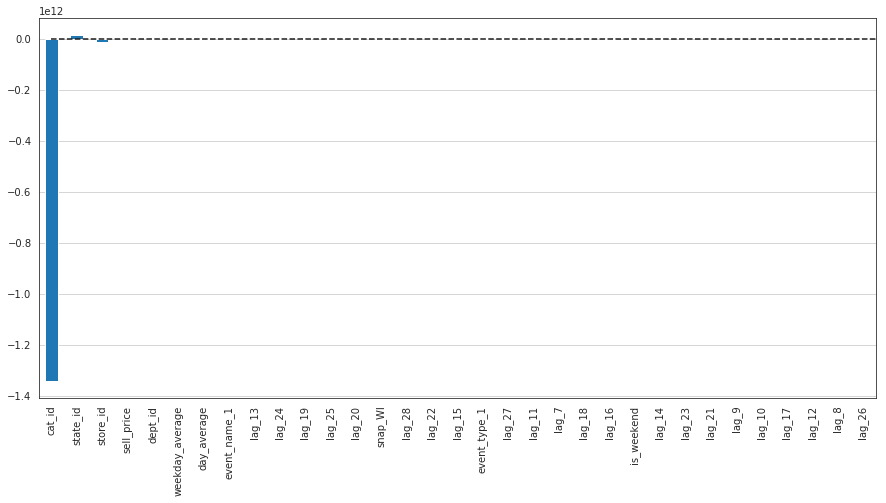

In [63]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

Aparentemente vemos Overfitting! Algumas features tiveram uma importancia negativa tão grande no conjunto de dados de treinamento que o modelo decidiu concentrar todas as suas forças nele. Como resultado, a qualidade da previsão caiu. Esse problema pode ser resolvido de várias maneiras; por exemplo, podemos calcular a codificação de destino não para todo o conjunto de treinamento, mas para algumas janelas. Dessa forma, as codificações da última janela observada provavelmente descreverão melhor o estado atual da série. Como alternativa, podemos simplesmente descartá-lo manualmente, pois temos certeza de que isso piora as coisas neste caso.

In [64]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5.4 Regularization e Feature Selection 

Como já sabemos, nem todos as features são igualmente importantes - alguns podem levar a overfitting, enquanto outras devem ser removidas. Além da inspeção manual, podemos aplicar a regularização. Dois dos modelos de regressão mais populares com regularização são as regressões de Ridge e Lasso. Ambos adicionam mais algumas restrições à nossa função de perda.

No caso da regressão de Ridge, essas restrições são a soma dos quadrados dos coeficientes multiplicados pelo coeficiente de regularização. Quanto maior o coeficiente de uma feature, maior será a nossa perda. Portanto, tentaremos otimizar o modelo, mantendo os coeficientes razoavelmente baixos.

Como resultado dessa regularização de $L2$, teremos um viés mais alto e uma menor variação, de modo que o modelo generalize melhor (pelo menos é o que esperamos que aconteça).

O segundo modelo de regressão, regressão de Lasso, adiciona à função de perda, não quadrados, mas valores absolutos dos coeficientes. Como resultado, durante o processo de otimização, os coeficientes das features sem importância podem se tornar zeros, o que permite a seleção automatizada de recursos. Esse tipo de regularização é chamado $L1$.

Primeiro, vamos ter certeza de que temos features a serem descartadas e que os dados possuem features altamente correlacionadas.

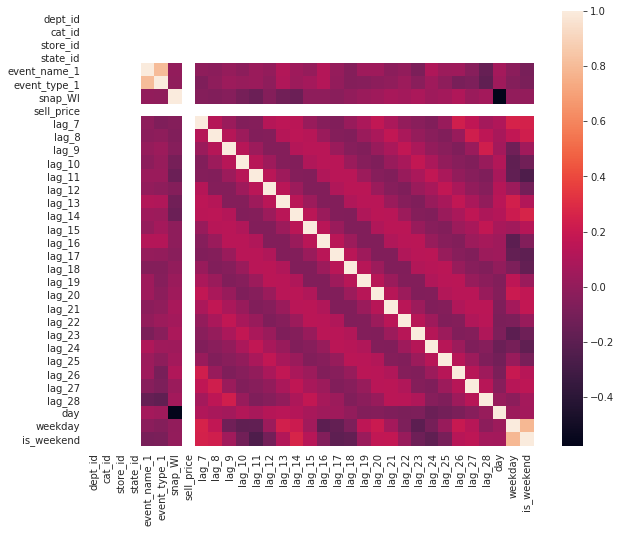

In [65]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

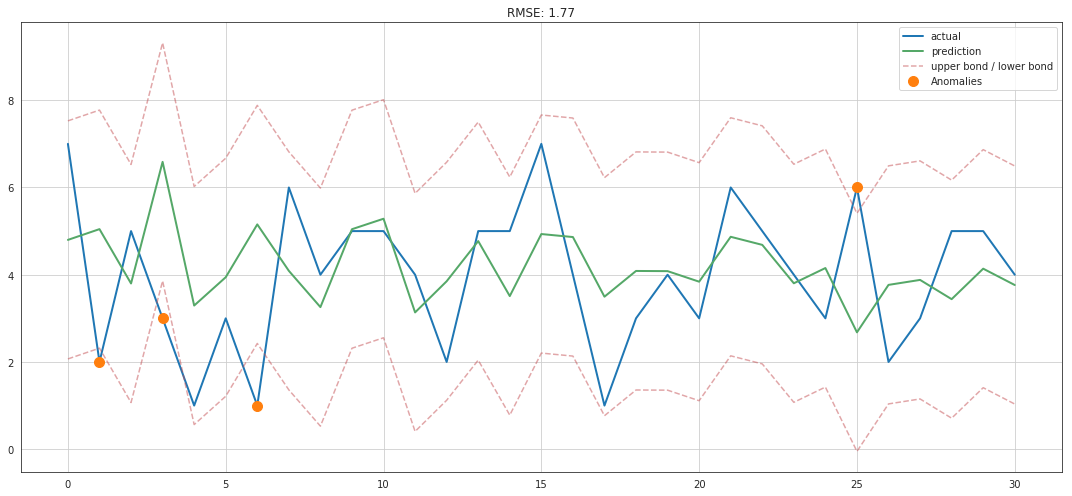

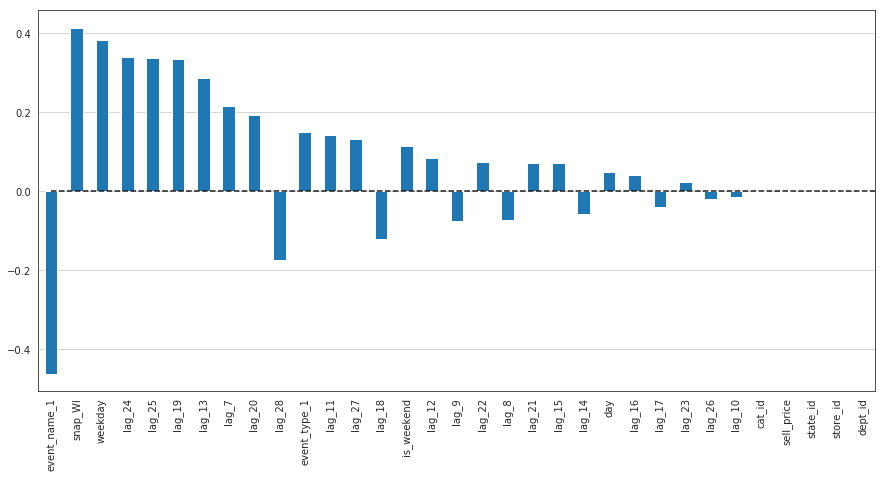

In [66]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(ridge)

Podemos ver claramente que alguns coeficientes estão se aproximando cada vez mais de zero (embora eles nunca cheguem a ele) à medida que sua importância no modelo diminui.

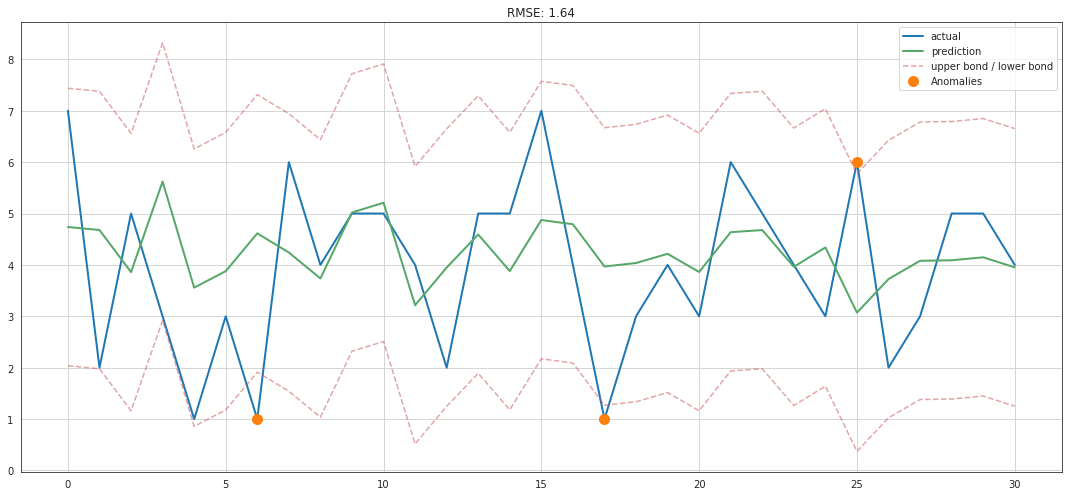

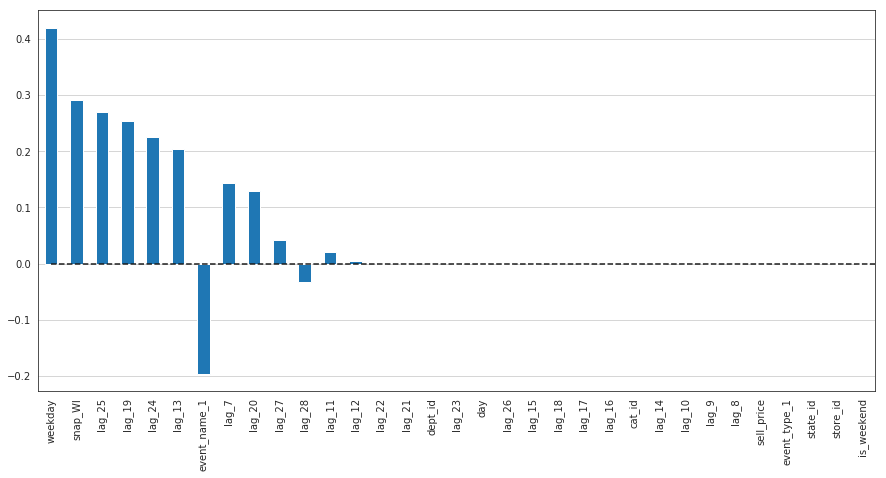

In [67]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(lasso)

A regressão Lasso acabou sendo mais conservadora; removeu algumas lag features importantes o que piorou a qualidade da previsão.

# Part 6. XGBoost e LightGBM

In [68]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

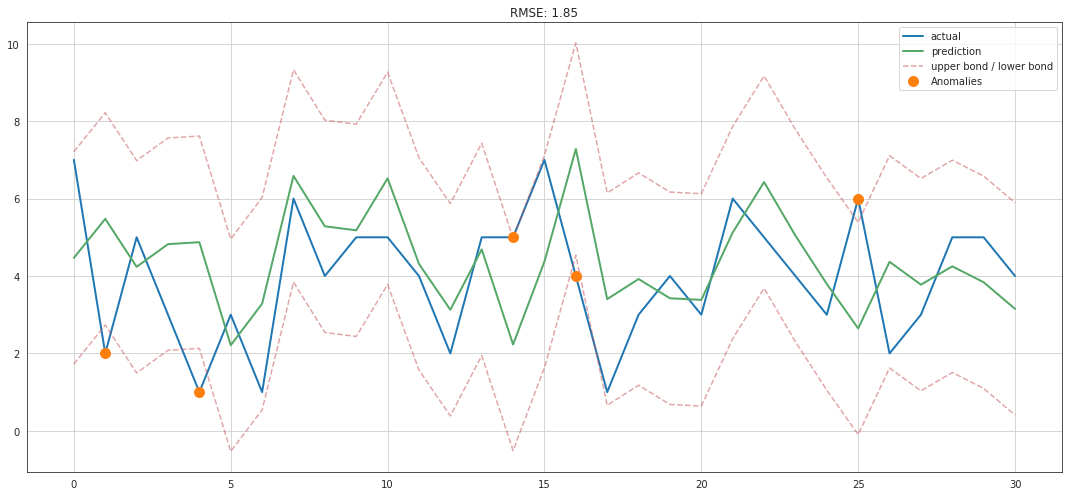

In [69]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)

In [70]:
from lightgbm import LGBMRegressor 

lgb = LGBMRegressor()
lgb.fit(X_train_scaled, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

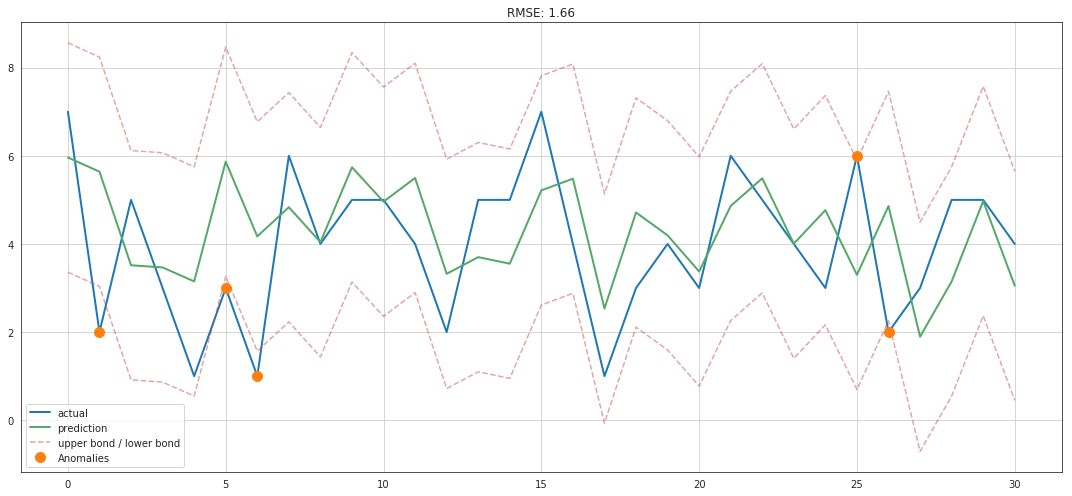

In [71]:
plotModelResults(lgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)